In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import random
import torch.nn.functional as F

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
random.seed(42)
g = torch.Generator()
g.manual_seed(42)

In [3]:
def resize_encoder(sample):
    sample = sample.unsqueeze(0)
    sample = F.interpolate(
        sample, size=(144, 72), mode="bicubic", align_corners=False
    )
    return sample.squeeze(0)


def random_mask(sample, mask_prob_low=0.7, mask_prob_high=0.7):
    if mask_prob_low == mask_prob_high:
        mask_prob = mask_prob_low
    else:
        mask_prob = random.uniform(mask_prob_low, mask_prob_high)
    random_tensor = torch.rand(sample.shape, device=sample.device)
    mask = (random_tensor > mask_prob).float()
    masked_image = sample * mask
    return masked_image


class WeatherBenchDataset(Dataset):
    def __init__(self, data, mask_prob_low=0.7, mask_prob_high=0.7):
        self.data = data
        self.mask_prob_low = mask_prob_low
        self.mask_prob_high = mask_prob_high

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        X = self.data[idx]
        X_enc = resize_encoder(X)
        X_masked = random_mask(
            X_enc,
            mask_prob_low=self.mask_prob_low,
            mask_prob_high=self.mask_prob_high,
        )
        return X, X_masked

In [4]:
# See: https://arxiv.org/pdf/2407.15171
def gaussian_density(z_g, Z, sigma):
    z_g = z_g.float()
    Z = Z.float()

    if z_g.dim() == 1:
        z_g = z_g.unsqueeze(0)
        squeeze_out = True
    else:
        squeeze_out = False

    # Compute squared Euclidean distances:
    #   diff: (B, N, d)
    #   sq_dist: (B, N)
    diff = Z.unsqueeze(0) - z_g.unsqueeze(1)
    sq_dist = (diff**2).sum(dim=-1)

    weights = torch.exp(-sq_dist / (2 * sigma**2))
    D = weights.mean(dim=-1)

    return D.squeeze(0) if squeeze_out else D

In [5]:
# Realism Score
# https://arxiv.org/pdf/1904.06991
def realism_score(real_feats, gen_feats, k):
    N_r, D = real_feats.shape
    # Distance for nearest neighbours
    dist_rr = torch.cdist(real_feats, real_feats)
    # ignore self‐distance
    idx = torch.arange(N_r, device=real_feats.device)
    dist_rr[idx, idx] = float("inf")
    r_k, _ = dist_rr.kthvalue(k, dim=1)
    dist_gr = torch.cdist(gen_feats, real_feats)  # (N_g, N_r)
    # Realism matrix
    ratios = r_k.unsqueeze(0) / dist_gr  # (N_g, N_r)
    # Max over reals
    realism, _ = ratios.max(dim=1)
    return realism

In [6]:
def plot_image(xh, x_full):
    num_channels = xh.shape[0]
    _, axes = plt.subplots(2, num_channels, figsize=(4 * num_channels, 4))
    mode_labels = [
        "2m_temperature",
        "u_component_of_wind",
        "v_component_of_wind",
        "geopotential",
        "specific_humidity",
    ]
    for i in range(num_channels):
        ax = axes[0, i]
        ax.imshow(x_full[i], cmap="coolwarm")
        ax.set_title(mode_labels[i])
        ax.axis("off")
    for i in range(num_channels):
        ax = axes[1, i]
        ax.imshow(xh[i], cmap="coolwarm")
        ax.set_title(mode_labels[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

In [7]:
latent_model = torch.load(
    "conditional_latent_model.pth", weights_only=False, map_location=DEVICE
)
model = torch.load(
    "simclr_decoder_freeze.pth", weights_only=False, map_location=DEVICE
)
latent_model.eval()
model.eval()

encoder_model = model.model.encoder
decoder_model = model.decoder

data = torch.load("/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt")
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
data = data[n_train + n_valid :]


BATCH_SIZE = 128
NUM_TIMES_TO_SAMPLE = 10
n_samples = data.shape[0]

n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)

train_data = data[:n_train]
valid_data = data[n_train : n_train + n_valid]
test_data = data[n_train + n_valid :]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

test_data = (test_data - mean) / std

In [8]:
test_dataset = WeatherBenchDataset(
    data=test_data, mask_prob_low=0.7, mask_prob_high=0.7
)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
# Encode the data

encoded_data = []
with torch.no_grad():
    for data in testloader:
        x_mask = data[1].to(DEVICE)
        x_mask_enc, _ = encoder_model(x_mask)
        encoded_data.append(x_mask_enc)

encoded_data = torch.cat(encoded_data, dim=0)

In [10]:
# Generate some samples
batch = random.choice(list(testloader))
condition = batch[1].to(DEVICE)
condition, _ = encoder_model(condition)

# Take the average generated image
zh_sum = torch.zeros(condition.shape[0], 1000).to(DEVICE)
for i in range(NUM_TIMES_TO_SAMPLE):
    with torch.no_grad():
        zh = latent_model.sample(condition.shape[0], 1000, condition)
    zh_sum += zh
zh_mean = zh_sum / NUM_TIMES_TO_SAMPLE

# Compute gaussian density score
gaussian_density_score = gaussian_density(z_g=zh_mean, Z=encoded_data, sigma=20.0)
gaussian_density_score = gaussian_density_score.mean()
print(f"Gaussian Density Score: {gaussian_density_score.item()}")

Gaussian Density Score: 0.3221234679222107


In [11]:
# Realism Score
realism_score_val = realism_score(real_feats=encoded_data, gen_feats=zh_mean, k=5)
realism_score_val = realism_score_val.mean()
print(f"Realism Score: {realism_score_val.item()}")

Realism Score: 0.11623721569776535


In [12]:
zh_mean = zh_mean.to(DEVICE)
with torch.no_grad():
    xh = decoder_model(zh_mean).cpu()
x_f = batch[0].cpu()


In [13]:
x_f = batch[0].cpu()
mse_loss = F.mse_loss(xh, x_f)
print(f"MSE Batch Loss: {mse_loss:.4f}")

MSE Batch Loss: 3.4710


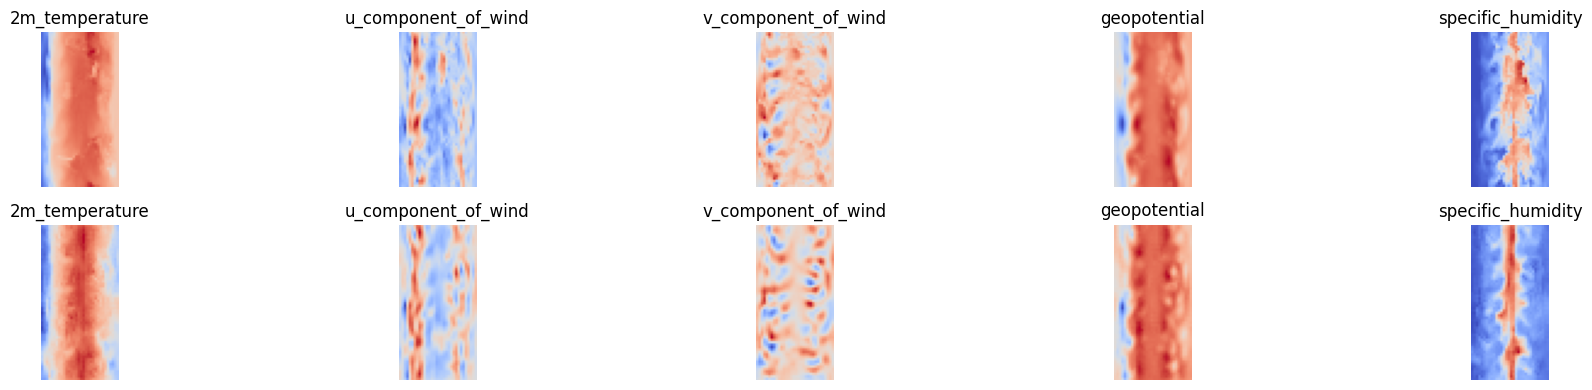

MSE Loss: 1.8825


: 

In [ ]:
xh = xh[0]
x_f = x_f[0]
mse_loss = F.mse_loss(xh, x_f)
xh = xh.numpy()
x_f = x_f.numpy()
plot_image(xh, x_f)
print(f"MSE Loss: {mse_loss:.4f}")